<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

Aluno: Raul Pichinin


---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

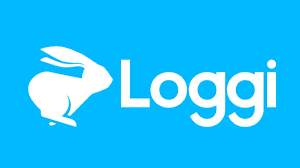




A **Loggi** é uma empresa brasileira de logística que atua principalmente no setor de e-commerce. Fundada em 2013 na cidade de São Paulo, pelo empresário francês Fabien Mendez e pelo brasileiro Arthur Debert.

A empresa possui serviços de coletas de encomendas para grandes, médias e pequenas empresas com entregas em todo o território nacional, além de serviços de entrega para escritórios e pessoas físicas, também para todo o país por meio de parcerias com entregadores autônomos (MEI).

O **Loggi Benchmark for Urban Deliveries** é uma plataforma dentro do GitHub que traz um conjunto de dados e scripts de benchmark para resolução de problemas relacionados a otimização de entregas urbanas.

As informações utilizadas na **LoggiBUD** são baseadas em fontes públicas, como o desenho no mapa de cada setor censitário (IPEA) e a renda domiciliar de cada setor (Censo IBGE 2010), e também no número médio de entregas realizadas em cada cidade em que a Loggi opera. Na plataforma, nenhuma entrega real da Loggi é divulgada, garantindo a privacidade dos clientes. A plataforma, além de fatores econômicos, também considera a geografia dos locais representados e as distâncias reais de viagem nas ruas para sugerir as melhores rotas.

Nesta estudo, em específico, foram analisados dados relacionados ao Distrito Federal.




## 2\. Pacotes e bibliotecas

In [1]:
# instalando Geopandas # Biblioteca Python que permite a manipulação e análise de dados geoespaciais.
!pip3 install geopandas;
...

Ellipsis

In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 3\. Exploração de dados

 3.1 - Coleta de Dados

In [4]:
# Trazendo os dados disponíveis pelo professor...
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json
# dados Geocodificação...
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv
# mapas dados do mapa do Distrito Federal do site do IBGE...
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

3.2. Data Wrangling

In [5]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

# Transformando o arquivo JSON em uma dataframe e mostrando os primeiros valores.
deliveries_df = pd.DataFrame (data)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Repare que a coluna origin contém dados aninhados na estrutura do JSON. Vamos normalizar a coluna com uma operação conhecida como **flatten** ou **achatamento**, que transforma cada chave do JSON em uma nova coluna:

In [6]:
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


Com o dados achatados, vamos juntá-los ao conjunto de dados principal:

In [7]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145


In [8]:
# removendo coluna origin...
deliveries_df = deliveries_df.drop("origin", axis=1)
# reordenação das colunas...
deliveries_df = deliveries_df[ ["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.head()

,name,region,lng,lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [9]:
# renomeando colunas...
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [10]:
# Outra explosao, agora da coluna 'deliveries' que também contém dados aninhados...
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [11]:
# Normalizando o dataframe resultante da explosão da coluna 'deliveries' e nomeando cada coluna...
deliveries_normalized_df = pd.concat([
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
    pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


In [12]:
# com o dados explodidos, vamos normalizá-los para combiná-los ao conjunto de dados principal...
deliveries_df = deliveries_df.drop("deliveries", axis=1)

deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True) # combinação usando as chaves do dataframe à direita
deliveries_df.reset_index(inplace=True, drop=True) # reset índices
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


3.3. Estrutura

In [13]:
deliveries_df.shape

(636149, 8)

In [14]:
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [15]:
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [16]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


3.4. Schema

In [17]:
deliveries_df.head(n=5)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [18]:
deliveries_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

In [19]:
#Analisando atributos categóricos...
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [20]:
#Analisando atributos numéricos...
deliveries_df.drop( ["name", "region"], axis=1 ).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


3.5. Dados Faltantes

In [21]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

## 4\. Manipulação

A geocodificação é o processo que transforma uma localização descrita por um texto (endereço, nome do local etc.) em sua respectiva coodernada geográfica (latitude e longitude).

In [22]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [23]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 46410411,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.0533433333333333,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-127, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state

In [24]:
# Aplicando a geocodificação nas coordenadas das três regiões e extrair informações de cidade e bairro...
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [25]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str) + "," + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248,-47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334,-47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274,-48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [26]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.100010,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [27]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]

hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [28]:
#O DataFrame hub_geodata_df com as informações de cidade e bairro é, então, combinado ao DataFrame principal deliveries_df enriquecendo assim o dado...
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [29]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


Geocodificação reversa da entrega Enquanto o hub contem apenas 3 geolocalizações distintas, as entregas somam o total de 636.149, o que levaria em torno de 7 dias para serem consultadas no servidor do **Nominatim**, dada a restrição de uma consulta por segundo. Contudo, para cargas pesadas como esta, o software oferece uma instalação local (na sua própria máquina) que pode ser utilizada sem restrição.

Para esta atividade o Professor já disponibilizou o arquivo em CSV.

In [30]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [31]:
#Combinando os DataFrame...
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


4.1 Qualidade

In [32]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [33]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [34]:
# Porcentagem dados nulos...
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

0.26754738276724477

In [35]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

In [36]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
Name: count, dtype: float64

In [37]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
Name: count, dtype: float64

## 5\. Visualização

In [38]:
# DataFrame mapa a partir dos dados baixados...
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [39]:
#Mapa dos Hubs...
#DataFrame geo_hub_df através do DataFrame deliveries_df. Nova coluna geometry:

hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [40]:
#Mapa das entregas...
#DataFrame geo_deliveries_df através do DataFrame deliveries_df. Nova coluna geometry:

geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


<ipython-input-41-f1c7b4474a95>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


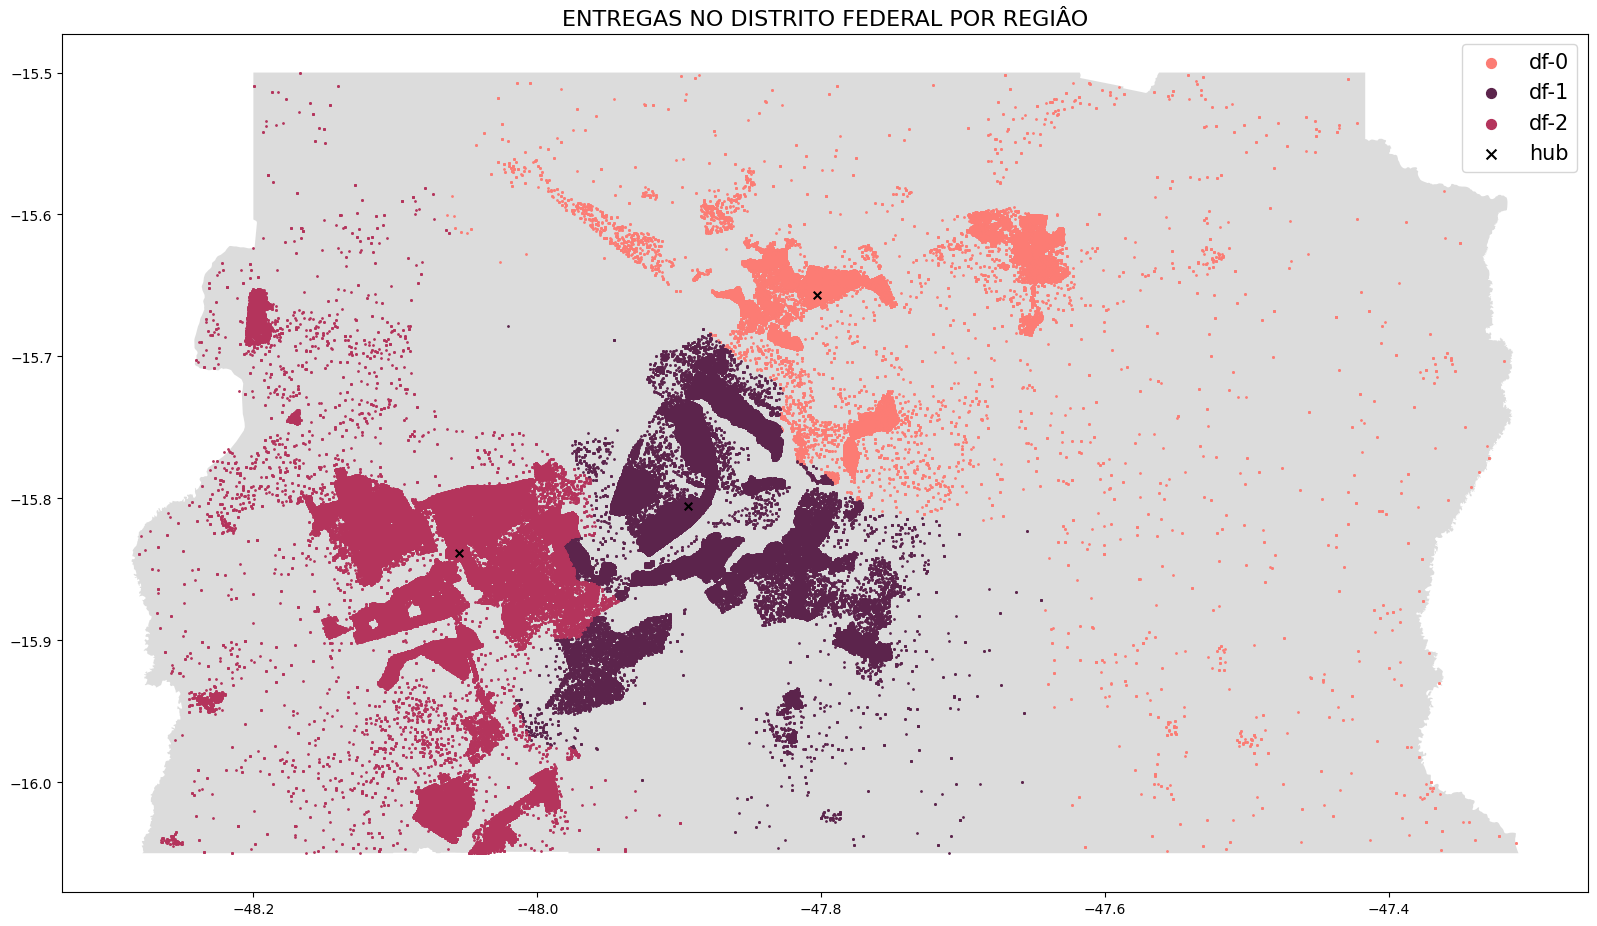

In [41]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="darkgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="#fc7c74", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="#5c244c", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="#b4345c", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda e título
plt.title("ENTREGAS NO DISTRITO FEDERAL POR REGIÂO", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
  handle.set_sizes([50])

**Insights:**

O hub df-1 atende em uma região mais centralizada. Já df-0 e df- 2 fazem mais entregas afastadas do centro.

Os hubs estão localizados perto de onde há mais entregas.

Há uma região acima do hub df-1 (NOROESTE) e abaixo (SUDOESTE) com poucas entregas.



5.1 Gráfico de entregas por região

In [42]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,proportion
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


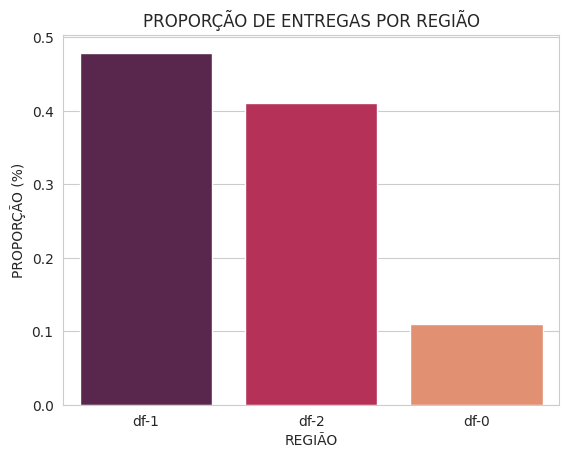

In [43]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="proportion", errorbar=None, palette='rocket')
  grafico.set(title='PROPORÇÃO DE ENTREGAS POR REGIÃO', xlabel='REGIÃO', ylabel='PROPORÇÃO (%)')


**Insights:**

A partir do gráfico, é possível perceber uma diferença na **quantidade** de entregas realizadas pelo **hub df-0** em comparação às quantidades dos outros dois hubs que apresentam valores maiores e mais próximos.

Contudo a capacidade dos veículos é a mesma para todos os hubs, logo os veículos poderiam ser deslocados para as regiões de maior tráfego. Outra ideia seria alocar veiculos com menor capacidade para a região df-0.

Lembrando também que mesmo o **hub df-0** tendo menor quantidade de entrgas, ele atende regiões mais distantes. Neste caso motos poderia ajudar.

Lista dos bairros por quantidade de entregas.

In [44]:
deliveries_df['delivery_city'].value_counts()

delivery_city
Brasília                       148983
Taguatinga                      45564
Sudoeste / Octogonal            44215
Ceilândia                       37953
Águas Claras                    37083
Guará                           35382
Lago Sul                        29021
Sobradinho                      28889
Lago Norte                      25975
Gama                            22189
Samambaia                       21081
Planaltina                      19095
Vicente Pires                   14869
Jardim Botânico                 12257
Santa Maria                     11529
Cruzeiro                        11296
Recanto das Emas                10131
Park Way                         9416
Sobradinho II                    8111
Arniqueiras                      7823
São Sebastião                    7710
Riacho Fundo                     6786
Brazlândia                       6043
Paranoá                          5952
Núcleo Bandeirante               5902
Itapoã                           556

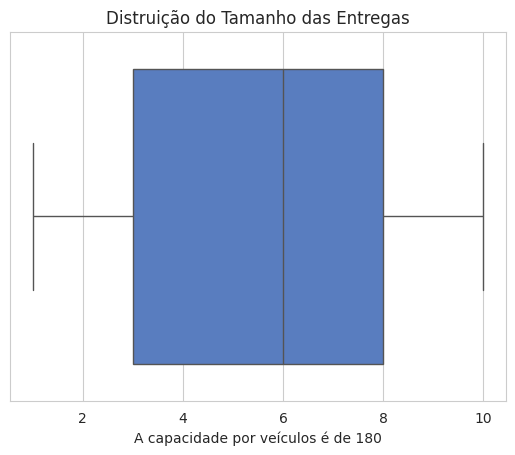

In [45]:
with sns.axes_style('whitegrid'):
    grafico = sns.boxplot(x=deliveries_df['delivery_size'], palette='muted')
    grafico.set(title='Distruição do Tamanho das Entregas', xlabel='A capacidade por veículos é de 180')

In [46]:
deliveries_df['delivery_size'].mean()

5.512111156348591

**Insights:**

É possível perceber que a média das entregas em tamanho é de 5,5.
Sabendo que cada veículo tem a capacidade de 180 entregas,
cada veículo consegue transportar 30 entregas por vez.